In [1]:
def greet(user_input: str)-> str:
  """
  Respond to a user greeting in a friendly way.
  If user_input doesn't seem like a greeting, provide a fallback message.

  Args:
      user_input: The user's text
  Returns:
      A greeting if user_input is recognized as a greeting; otherwise a fallback
  """
  greetings = ["hello", "hi", "hey", "greetings", "good morning", "good afternoon", "good evening"]
  lower_input = user_input.lower()

  if any(g in lower_input for g in greetings):
    return "Hello there! How can I help you today?"
  else:
    return "I only handle greetings right now. Try saying 'Hello'!"

In [2]:
!pip install langchain_google_genai
!pip install langchain_core
!pip install langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.4 MB/s eta 0:00:00


In [26]:
from google.colab import userdata
# import google.generativeai as genai

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
# genai.configure(api_key=GEMINI_API_KEY)

In [20]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY,
)

tools = [greet]
llm_with_tools = llm.bind_tools(tools)

In [8]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content=
 (
  """
  You are a helpful assistant.
  You have a Python function named 'greet' that you can call to handle user greetings.
  If the user says something not greeting-related, still call 'greet' to show a fallback.
  """
  )
)

In [21]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, AIMessage

def assistant(state: MessagesState):
  """
    The node that calls the LLM (which can decide to use greet()).
  """
  all_msgs = [sys_msg] + state['messages']
  response_msg = llm_with_tools.invoke(all_msgs)
  return {"messages": [response_msg]}

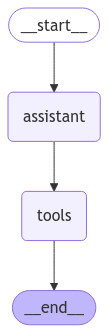

In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

tool_node = ToolNode(tools)

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

builder.add_edge(START, "assistant")
builder.add_edge("assistant", "tools")
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [30]:
messages = [HumanMessage(content="good morning")]
result = graph.invoke({"messages": messages})
for m in result["messages"]:
  m.pretty_print()


================================ Human Message =================================

good morning
================================== Ai Message ==================================
Tool Calls:
  greet (96b65dd6-d1c1-4e76-82de-478272370ed8)
 Call ID: 96b65dd6-d1c1-4e76-82de-478272370ed8
  Args:
    user_input: good morning
================================= Tool Message =================================
Name: greet

Hello there! How can I help you today?
